In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

# Paths to the dataset
UNZIP_PATH = '../input/data-science-bowl-2018/'
TRAIN_ZIP = UNZIP_PATH + 'stage1_train.zip'
TEST_ZIP = UNZIP_PATH + 'stage1_test.zip'
TRAIN_PATH = './train/'
TEST_PATH = './test/'

# Image properties
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Unzip the dataset
with zipfile.ZipFile(TRAIN_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TRAIN_PATH)
    
with zipfile.ZipFile(TEST_ZIP, 'r') as zip_ref:
    zip_ref.extractall(TEST_PATH)

# Get list of all subfolders
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Initialize arrays for train and test images
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Load training images and masks
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):  
    path = TRAIN_PATH + id_  
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  
    X_train[n] = img  
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)  
    for mask_file in next(os.walk(path + '/masks/'))[2]:  
        mask_ = imread(path + '/masks/' + mask_file)  
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Load test images
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):  
    path = TEST_PATH + id_  
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  
    X_test[n] = img


def conv_block(input_tensor, num_filters):
    """A function to build the convolutional block for U-Net."""
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(input_tensor)
    x = Conv2D(num_filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(input_tensor, num_filters):
    """A function to build the encoder block for U-Net."""
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, concat_tensor, num_filters):
    """A function to build the decoder block for U-Net."""
    x = UpSampling2D((2, 2))(input_tensor)
    x = Concatenate()([x, concat_tensor])
    x = conv_block(x, num_filters)
    return x

def unet_model(input_shape):
    """Function to define the U-Net model."""
    inputs = Input(input_shape)
    s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) 

    # Encoder
    x1, p1 = encoder_block(s, 16)
    x2, p2 = encoder_block(p1, 32)
    x3, p3 = encoder_block(p2, 64)
    x4, p4 = encoder_block(p3, 128)
    x5, p5 = encoder_block(p4, 256)
    x6, p6 = encoder_block(p5, 512)


    # Bridge
    bridge = conv_block(p6, 1024)

    # Decoder
    d1 = decoder_block(bridge, x6, 512)
    d2 = decoder_block(d1, x5, 256)
    d3 = decoder_block(d2, x4, 128)
    d4 = decoder_block(d3, x3, 64)
    d5 = decoder_block(d4, x2, 32)
    d6 = decoder_block(d5, x1, 16)

    # Output
    outputs = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(d6)

    model = tf.keras.Model(inputs, outputs)
    return model


100%|██████████| 65/65 [00:01<00:00, 38.62it/s]


In [2]:
# Determine the input shape for the U-Net model
input_shape = X_train.shape[1:]  # This takes the shape of the images, ignoring the batch size

# Create the U-Net model
model = unet_model(input_shape)

# Now the model is created, you can compile and train it
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_split=0.1)


Epoch 1/10
38/38 [==============================] - 132s 3s/step - loss: 0.6759 - accuracy: 0.7499 - val_loss: 0.6322 - val_accuracy: 0.7682
Epoch 2/10
38/38 [==============================] - 123s 3s/step - loss: 0.5580 - accuracy: 0.7618 - val_loss: 0.4493 - val_accuracy: 0.8027
Epoch 3/10
38/38 [==============================] - 123s 3s/step - loss: 0.3321 - accuracy: 0.8542 - val_loss: 0.2621 - val_accuracy: 0.9044
Epoch 4/10
38/38 [==============================] - 123s 3s/step - loss: 0.2102 - accuracy: 0.9185 - val_loss: 0.1723 - val_accuracy: 0.9402
Epoch 5/10
38/38 [==============================] - 123s 3s/step - loss: 0.1356 - accuracy: 0.9471 - val_loss: 0.1288 - val_accuracy: 0.9491
Epoch 6/10
38/38 [==============================] - 124s 3s/step - loss: 0.1279 - accuracy: 0.9502 - val_loss: 0.1278 - val_accuracy: 0.9501
Epoch 7/10
38/38 [==============================] - 124s 3s/step - loss: 0.1190 - accuracy: 0.9534 - val_loss: 0.1310 - val_accuracy: 0.9464
Epoch 8/10
38

In [3]:
# If you have ground truth for the test data
#test_loss, test_acc = model.evaluate(X_test, Y_test)

# Predict on test data
predictions = model.predict(X_test, verbose=1)

3/3 [==============================] - 2s 440ms/step


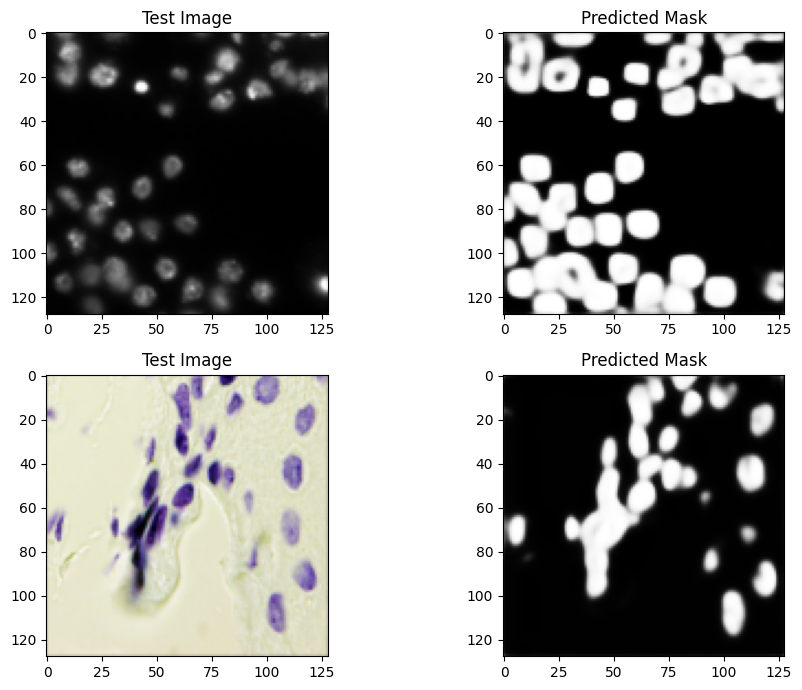

In [4]:
import matplotlib.pyplot as plt

# Visualize some predictions
n = 2  # Number of images to visualize
fig, axes = plt.subplots(n, 2, figsize=(10, 7))
axes = axes.ravel()

for i in range(n):
    ix = np.random.randint(0, len(X_test))
    axes[2*i].imshow(X_test[ix])
    axes[2*i].set_title('Test Image')
    axes[2*i+1].imshow(predictions[ix].squeeze(), cmap='gray')
    axes[2*i+1].set_title('Predicted Mask')

plt.tight_layout()
plt.show()
